In [ ]:
# GPU 사용 확인
import torch

if torch.cuda.is_available():
    print("✅ GPU 사용 가능:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU 사용 불가. [런타임 → 런타임 유형 변경]에서 GPU 설정 확인")

✅ GPU 사용 가능: Tesla T4


# colab에서 다운로드 및 압축 해제

In [ ]:
# 1. gdown 설치
!pip install -U gdown

# 2. Google Drive 공유 파일 다운로드
!gdown --id 11XaLQaUtdDjmIcFHQtIzfTKaxMzLNz_7 --output /content/scin_data.zip

# 3. 압축 해제
import zipfile

zip_path = '/content/scin_data.zip'
extract_path = '/content/scin_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ 압축 해제 완료! 압축 풀린 경로:", extract_path)

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11XaLQaUtdDjmIcFHQtIzfTKaxMzLNz_7
From (redirected): https://drive.google.com/uc?id=11XaLQaUtdDjmIcFHQtIzfTKaxMzLNz_7&confirm=t&uuid=184deba6-38ef-45db-aac1-69f26b72e3c2
To: /content/scin_data.zip
100% 12.5G/12.5G [02:50<00:00, 73.3MB/s]
✅ 압축 해제 완료! 압축 풀린 경로: /content/scin_data


# scin_cases 메타데이터 전처리

### 1. 데이터 불러오기 및 병합

In [ ]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# 1. 파일 경로 설정
cases_path = '/content/scin_data/content/scin_data/dataset/scin_cases.csv'
labels_path = '/content/scin_data/content/scin_data/dataset/scin_labels.csv'

# 2. 데이터 불러오기 및 병합
df_cases = pd.read_csv(cases_path)
df_labels = pd.read_csv(labels_path)
df = pd.merge(df_cases, df_labels, on='case_id', how='inner')
df = df[df['weighted_skin_condition_label'].astype(str) != '{}']

### 2. 기본 전처리 및 인코딩

In [ ]:
# 3. 컬럼명 소문자화
df.columns = df.columns.str.strip().str.lower()

# 4. 다중 범주 이진화 컬럼 정의
multi_keys = ['textures_', 'body_parts_', 'condition_symptoms_', 'other_symptoms_', 'race_ethnicity_']
multi_cols = [col for col in df.columns if any(key in col for key in multi_keys)]

# 5. 문자열 결측 처리
fill_str_cols = [
    'sex_at_birth', 'fitzpatrick_skin_type', 'combined_race', 'condition_duration',
    'dermatologist_fitzpatrick_skin_type_label_1',
    'dermatologist_fitzpatrick_skin_type_label_2',
    'dermatologist_fitzpatrick_skin_type_label_3'
]
for col in fill_str_cols:
    if col in df.columns:
        df[col] = df[col].fillna('unspecified').str.lower().str.strip()

# 6. age_group 인코딩
df['age_group'] = (
    df['age_group'].fillna('unknown')
    .str.lower().str.replace('age_', '', regex=False)
    .str.replace('_to_', '-', regex=False).str.strip()
)
age_order = ['0-9','10-17','18-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','unknown']
df['age_group_ordinal'] = df['age_group'].map({v: i for i, v in enumerate(age_order)}).fillna(-1).astype(int)

# 7. 성별 원-핫 인코딩
df = pd.get_dummies(df, columns=['sex_at_birth'], prefix='sex')
sex_cols = [col for col in df.columns if col.startswith('sex_')]
df[sex_cols] = df[sex_cols].astype(int)

# 8. 피부타입 인코딩
fitz_map = {'fst1': 1, 'fst2': 2, 'fst3': 3, 'fst4': 4, 'fst5': 5, 'fst6': 6, 'unspecified': 0}
fitz_cols = ['fitzpatrick_skin_type'] + [f'dermatologist_fitzpatrick_skin_type_label_{i}' for i in range(1, 4)]
for col in fitz_cols:
    df[f'{col}_encoded'] = df[col].map(fitz_map).fillna(0).astype(int)

# 9. condition_duration 인코딩
duration_order = [
    'one_day','less_than_one_week','one_to_four_weeks','one_to_three_months',
    'three_to_twelve_months','more_than_one_year','more_than_five_years',
    'since_childhood','unknown','unspecified'
]
df['condition_duration_encoded'] = df['condition_duration'].map({v: i for i, v in enumerate(duration_order)}).fillna(-1).astype(int)

# 10. 관련 카테고리 one-hot 인코딩
df['related_category'] = df['related_category'].fillna('unknown').str.lower().str.strip()
df = pd.get_dummies(df, columns=['related_category'], prefix='rc')

# 11. 다중 범주 이진화
for col in multi_cols:
    df[col] = df[col].notna().astype(int)

### 3. 이미지 및 shot type 정보 정리

In [ ]:
# 12. 이미지 shot type 인코딩 준비
image_cols = ['image_1_path', 'image_2_path', 'image_3_path']
shot_type_cols = {
    'image_1_path': [col for col in df.columns if col.startswith('image_1_shot_type')],
    'image_2_path': [col for col in df.columns if col.startswith('image_2_shot_type')],
    'image_3_path': [col for col in df.columns if col.startswith('image_3_shot_type')],
}
df['original_index'] = df.index

def is_positive(val):
    return str(val).strip().lower() in ['1', 'true', 'yes']

# 13. 이미지 long 포맷으로 변환
df_long = df.melt(
    id_vars=[col for col in df.columns if col not in image_cols],
    value_vars=image_cols,
    var_name='image_source',
    value_name='image'
)
df_long = df_long[df_long['image'].notna() & (df_long['image'].astype(str).str.strip() != '')].reset_index(drop=True)
df_long['image_num'] = df_long['image_source'].str.extract(r'image_(\d)_path')

# ✅ 14. shot_type 이름 정확히 유지한 추출
shot_type_final = []
for row in df_long.itertuples():
    img_num = row.image_num
    original_idx = row.original_index
    matching_cols = shot_type_cols.get(f'image_{img_num}_path', [])
    shot_values = df.loc[original_idx, matching_cols] if matching_cols else []
    shot_type = [col.replace(f'image_{img_num}_shot_type_', '') for col in matching_cols if is_positive(shot_values[col])]
    shot_type_final.append(shot_type)

df_long['image_shot_type_list'] = shot_type_final
mlb_shot = MultiLabelBinarizer()
shot_dummies = pd.DataFrame(mlb_shot.fit_transform(df_long['image_shot_type_list']),
                            columns=['image_shot_type_' + cls for cls in mlb_shot.classes_])
df_long = pd.concat([df_long, shot_dummies], axis=1)


### 4. 병명 멀티레이블 정리

In [ ]:
# 15. 고유 case_id 업데이트
df_long['case_id'] = df_long['case_id'].astype(str) + '_' + df_long['image_source'].str.extract(r'image_(\d)_path')[0]

# 16. 정리
original_shot_type_cols = sum(shot_type_cols.values(), [])
drop_cols = ['image_source', 'image_num', 'original_index', 'image_shot_type_list']
df_long.drop(columns=drop_cols + original_shot_type_cols, inplace=True)

# 17. 이미지 경로 정리
df_long['image'] = df_long['image'].astype(str).str.strip()
df_long = df_long[df_long['image'] != '']
df_long = df_long.drop_duplicates(subset='image', keep='first').reset_index(drop=True)

# 18. 병명 멀티레이블 파싱
def extract_multi_labels(label_str, threshold=0.3):
    try:
        label_dict = ast.literal_eval(label_str)
        return [k.strip() for k, v in label_dict.items() if v >= threshold]
    except:
        return []

df_long['multi_labels'] = df_long['weighted_skin_condition_label'].apply(extract_multi_labels)

# 19. 병명 원-핫 인코딩
mlb = MultiLabelBinarizer()
label_lists = mlb.fit_transform(df_long['multi_labels'])
label_names = ['label_' + l.replace(' ', '_').replace('/', '_').lower() for l in mlb.classes_]
label_dummies = pd.DataFrame(label_lists, columns=label_names)


### 5. 기타 변환 및 필터링

In [ ]:
# 20. TRUE/FALSE 문자열을 1/0으로 변환
bool_like_cols = df_long.columns[df_long.apply(lambda col: col.astype(str).str.upper().isin(['TRUE', 'FALSE']).all())]
for col in bool_like_cols:
    df_long[col] = df_long[col].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})

# 21. 전체 병합
df_all_labels = pd.concat([df_long.drop(columns=['weighted_skin_condition_label', 'multi_labels']), label_dummies], axis=1)

# 22. 희소 레이블 제거 + 범주형 원본 제거
label_counts = label_dummies.sum()
rare_labels = label_counts[label_counts <= 10].index.tolist()
df_filtered = df_all_labels[~df_all_labels[rare_labels].any(axis=1)].drop(columns=rare_labels).reset_index(drop=True)

remove_cat_cols = [
    'fitzpatrick_skin_type', 'age_group', 'condition_duration', 'combined_race',
    'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2',
    'dermatologist_gradable_for_skin_condition_3', 'dermatologist_skin_condition_on_label_name',
    'dermatologist_skin_condition_confidence', 'dermatologist_gradable_for_fitzpatrick_skin_type_1',
    'dermatologist_gradable_for_fitzpatrick_skin_type_2', 'dermatologist_gradable_for_fitzpatrick_skin_type_3',
    'gradable_for_monk_skin_tone_india', 'gradable_for_monk_skin_tone_us',
    'monk_skin_tone_label_india', 'monk_skin_tone_label_us',
    'dermatologist_fitzpatrick_skin_type_label_1',
    'dermatologist_fitzpatrick_skin_type_label_2',
    'dermatologist_fitzpatrick_skin_type_label_3'
]
df_all_labels.drop(columns=[col for col in remove_cat_cols if col in df_all_labels.columns], inplace=True)
df_filtered.drop(columns=[col for col in remove_cat_cols if col in df_filtered.columns], inplace=True)


### 6. 저장 및 다운로드

In [ ]:
# 23. 저장
df_all_labels.to_csv('/content/processed_scin_all_labels.csv', index=False)
df_filtered.to_csv('/content/processed_scin_filtered_labels.csv', index=False)


# 24. 다운로드
from google.colab import files
files.download('/content/processed_scin_all_labels.csv')
files.download('/content/processed_scin_filtered_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# scin_cases 전처리 시각화

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. 데이터 로드
df_raw_cases = pd.read_csv('/content/scin_data/content/scin_data/dataset/scin_cases.csv')
df_raw_labels = pd.read_csv('/content/scin_data/content/scin_data/dataset/scin_labels.csv')
df_raw = pd.merge(df_raw_cases, df_raw_labels, on='case_id', how='inner')

df_proc = pd.read_csv('/content/processed_scin_filtered_labels.csv')

In [ ]:
# 공통 컬럼만 대상으로 필터링
common_cols = df_raw.columns.intersection(df_proc.columns)

# 결측값 개수 계산
missing_raw_common = df_raw[common_cols].isnull().sum().sort_values(ascending=False)
missing_proc_common = df_proc[common_cols].isnull().sum().sort_values(ascending=False)

# 상위 15개만 출력
print("Top 15 columns with missing values in Raw data:")
print(missing_raw_common.head(15))

print("\nTop 15 columns with missing values in Processed data:")
print(missing_proc_common.head(15))


Top 15 columns with missing values in Raw data:
race_ethnicity_native_hawaiian_or_pacific_islander    5029
race_ethnicity_middle_eastern_or_north_african        5026
race_ethnicity_other_race                             5017
race_ethnicity_prefer_not_to_answer                   4999
race_ethnicity_american_indian_or_alaska_native       4960
race_ethnicity_two_or_more_after_mitigation           4950
other_symptoms_fever                                  4943
race_ethnicity_asian                                  4937
other_symptoms_mouth_sores                            4937
body_parts_foot_sole                                  4929
other_symptoms_chills                                 4913
other_symptoms_shortness_of_breath                    4894
body_parts_palm                                       4818
body_parts_genitalia_or_groin                         4811
condition_symptoms_bleeding                           4808
dtype: int64

Top 15 columns with missing values in Processed data:

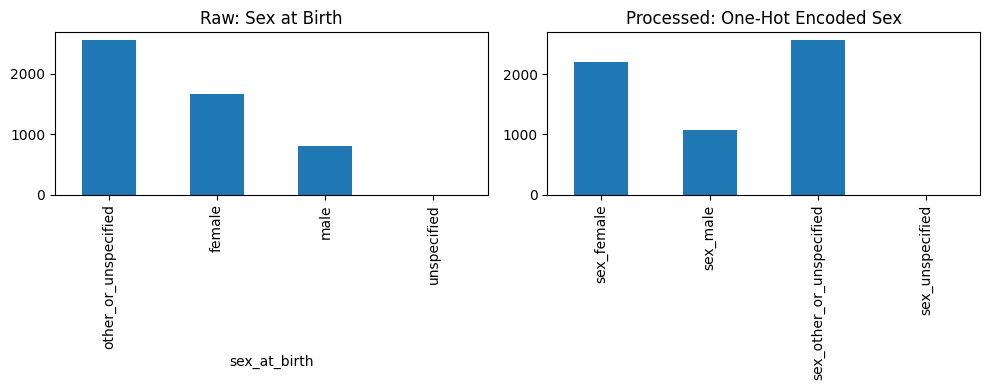

In [ ]:
# 성별 분포 (One-Hot 전후)
sex_cols = [col for col in df_proc.columns if col.startswith('sex_')]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df_raw['sex_at_birth'].fillna('unspecified').str.lower().value_counts().plot(kind='bar')
plt.title("Raw: Sex at Birth")

plt.subplot(1, 2, 2)
df_proc[sex_cols].sum().plot(kind='bar')
plt.title("Processed: One-Hot Encoded Sex")
plt.tight_layout()
plt.show()


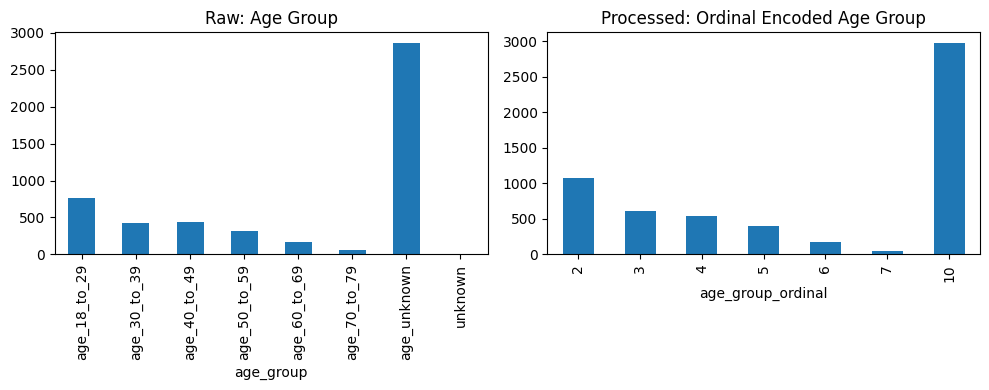

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df_raw['age_group'].fillna('unknown').str.lower().value_counts().sort_index().plot(kind='bar')
plt.title("Raw: Age Group")

plt.subplot(1, 2, 2)
df_proc['age_group_ordinal'].value_counts().sort_index().plot(kind='bar')
plt.title("Processed: Ordinal Encoded Age Group")
plt.tight_layout()
plt.show()


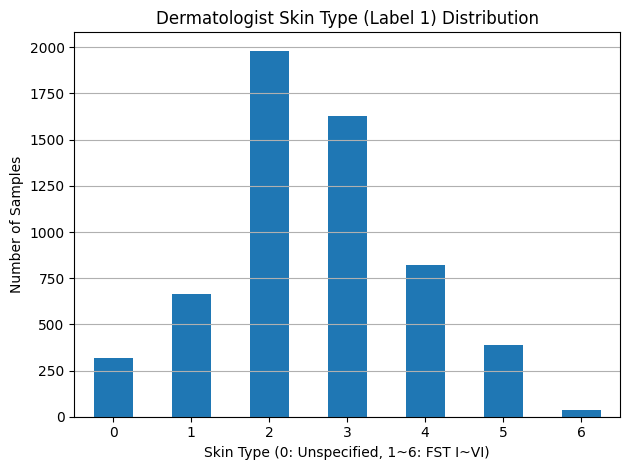

In [ ]:
import matplotlib.pyplot as plt

# 시각화 대상 컬럼
col = 'dermatologist_fitzpatrick_skin_type_label_1_encoded'

# 분포 시각화
if col in df_proc.columns:
    df_proc[col].value_counts().sort_index().plot(kind='bar')
    plt.title("Dermatologist Skin Type (Label 1) Distribution")
    plt.xlabel("Skin Type (0: Unspecified, 1~6: FST I~VI)")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print(f"❌ Column '{col}' not found in df_proc")

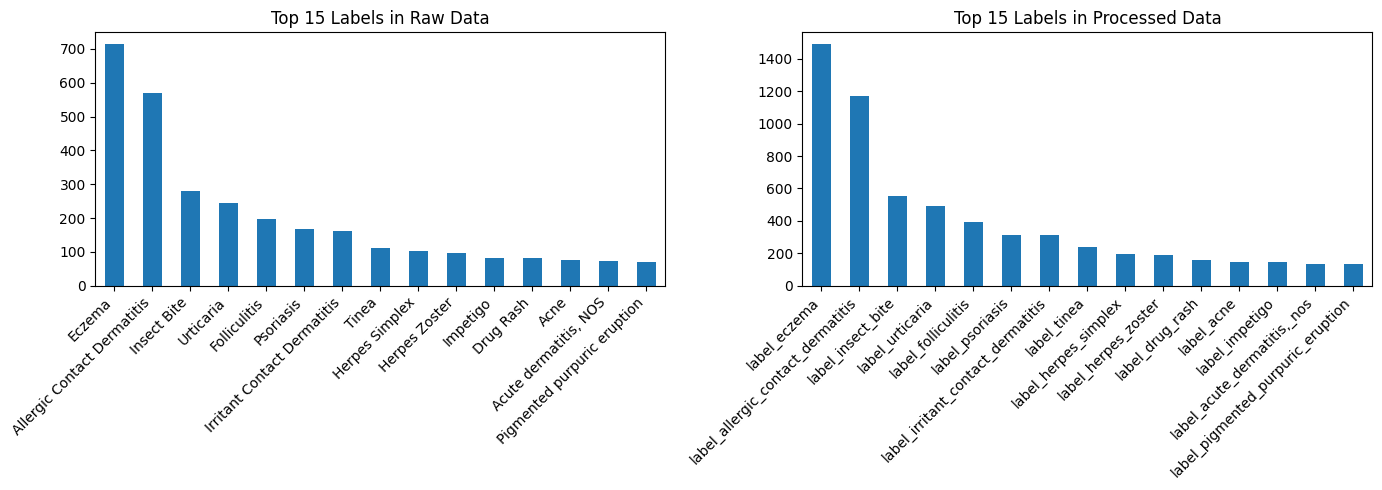

In [ ]:
# 병명 개수 비교 (전처리 전 vs 후)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
raw_label_series.head(15).plot(kind='bar')
plt.title("Top 15 Labels in Raw Data")
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
proc_label_counts.head(15).plot(kind='bar')
plt.title("Top 15 Labels in Processed Data")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
